# Who is being left out by public transport?
**An analysis of accessibility and public transport quality in Santiago, Chile**

**[Iacopo Garizio](https://iacopogarizio.com), University of Washington**

*Abstract*  
The city of Santiago, Chile, is highly segregated in terms of income and its car usage is unequal across the city, making the need for public transport also unequally distributed. The objective of this analysis is to discover what parts of the city are being underserved in terms of public transport. The analysis uses two different types of metrics (accessibility and quality) to answer this question. The study shows that in some areas of the city the type of metric used can change who is considered to be "left out," however, for the most part, it shows consistently that the outskirts of the city are the most underserved.

## 1. Motivation

Chile is a country with high inequality, where the [top 1% earns 26.5% of the revenues](https://radio.uchile.cl/2019/10/28/la-desigualdad-que-desperto-a-chile/), the [lowest 50% earns 2.1%](https://radio.uchile.cl/2019/10/28/la-desigualdad-que-desperto-a-chile/), and the [highest 10% earn 39.1 times more than the lowest 10%](https://radio.uchile.cl/2019/10/28/la-desigualdad-que-desperto-a-chile/). It is in this context that we have the city of Santiago, which is highly segregated in terms of income.

In the city of Santiago, nearly [30% of the population uses public transport on a daily basis](https://www.emol.com/noticias/nacional/2015/03/19/708778/mas-de-18-millones-de-viajes-diarios-se-realizan-en-santiago.html), and car usage is concentrated in wealthy areas. While the quality of the public transport service is [viewed as "good" when compared to other Latin American countries](https://www.elmostrador.cl/noticias/pais/2017/02/10/transantiago-no-es-el-mejor-del-mundo-pero-tampoco-el-peor-saca-la-puntuacion-mas-elevada-en-america-latina/), it is still far from perfect, especially considering that it is one of the most expensive public transport in the world (when accounting for mean income), [ranking 9th, just above London and New York](https://www.emol.com/noticias/Nacional/2019/10/18/964843/Chile-9no-mas-caro-transporte.html).

Income distribution        |  Car usage (López, 2019)
:-------------------------:|:-------------------------:
![Income distribution in Santiago](./images/income_distribution.jpg)  |  ![Car usage in Santiago](./images/car_usage.png)

## 2. Background

There are some previous studies that cover the topic of accessibility to public transport and equity in Santiago. What those studies have found is that some counties/communes with [low average income have less accessibility to bus stops](https://www.sciencedirect.com/science/article/abs/pii/S0739885915301025?via%3Dihub), and in some cases, the [physical stops and the paths people need to walk to get to those stops are also worse](https://journals-sagepub-com.offcampus.lib.washington.edu/doi/full/10.1177/0361198118782036).  
[Another study](http://www.infraestructurapublica.cl/estudio-revelo-las-dos-comunas-capitalinas-con-peores-indicadores-de-acceso-al-transporte/) has also found a negative correlation between wealth and access to public transport in Santiago. They show that "San Bernardo" and "La Pintana," two (on average) low-income counties/communes, have the worst accessibility to public transport, and also have the worse environment to walk.

## 3. Research question

Because of the conditions of Chile and the city of Santiago mentioned in section 1, this analysis aims to understand how the *quality* (in the broadest sense of the world) of the public transport is distributed across the city. My research question for the project is going to be **"Who is being left out by public transport?"** This analysis will try to discover what parts of the city are not being served correctly and in what way this is happening.  
I hypothesize that low-income groups outside the city center are the ones mostly excluded by public transport.

## 4. Methodology

In order to understand the dynamics between population and public transport, I first gathered census data and public transport information. Here are the details of each of them:
- [Microdatos Censo 2017 (Manzana)](https://geoine-ine-chile.opendata.arcgis.com/datasets/54e0c40680054efaabeb9d53b09e1e7a_0): This shapefile contains the number of people who live in each city block. According to the website, it is licensed under a custom license, which categorizes the dataset as "public use."  
    The data has the following structure:
    
| Field      | type     | Description                         |
|------------|----------|-------------------------------------|
| FID        | int      | Unique identifier of the city block |
| REGION     | str      | Name of the region                  |
| PROVINCIAL | str      | Name of the province                |
| COMUNA     | str      | Name of the county/commune          |
| TOTAL_PERS | int      | Total number of people              |
| geometry   | geometry | Shape of the city block             |
|            |          |                                     |

- [Santiago GTFS data](https://datos.gob.cl/dataset/33245): Dataset with bus stops, routes, times, among many others. This is licensed under Creative Commons Attribution.  
    The dataset follows the [standard GTFS structure](https://developers.google.com/transit/gtfs). Here is a summary of the fields used:
    
| File           | Field      | Type      | Description                                                                 |
|----------------|------------|-----------|-----------------------------------------------------------------------------|
| trips.txt      | service_id | int       | Identifies a set of dates when service is available for one or more routes  |
| stop_times.txt | trip_id    | int       | Identifies a trip                                                           |
| stops.txt      | stop_id    | int       | Identifies a stop                                                           |
| stops.txt      | stop_lat   | Latitude  | WGS84 latitude in decimal degrees                                           |
| stops.txt      | stop_lon   | Longitude | WGS84 longitude in decimal degrees                                          |

After the information was obtained, I perform three steps to obtain the final metrics:
1. Simulate the population on each city block
2. Process the GTFS data
3. Join the information from steps 1 and 2 to generate the metrics

The details of each of these steps are detailed below.

### 4.1 Simulating the population on each city block
Because the census data has only information at a city block level, I simulate the position of each person inside each city block (keeping a margin from the border of the block).

#### 4.1.1 Imports

In [1]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import random

#### 4.1.2 Loading the census data
Loading the census data and also filtering it using the region name ("REGIÓN METROPOLITANA DE SANTIAGO") and by coordinates.

In [2]:
blocks = gpd.read_file("zip://./data/chile_city_blocks.zip")
blocks.to_crs("EPSG:4326", inplace=True)

blocks = blocks[blocks.REGION == 'REGIÓN METROPOLITANA DE SANTIAGO'].copy()
blocks = blocks.cx[-70.8:70.4,-33.6:-33.3].copy()

#### 4.1.3 Creating helper functions
- *generate_random_points* generates *n* points that lay inside a given polygon. It works by randomizing points (one by one) inside the **bounds** of the polygon and then checking if they are contained inside the polygon. If any point is not contained, it simply simulates a new one. The function repeats this process until it has generated *n* valid points.  
- *concat_gdf_list* concatenates GeoDataFrames contained in a list maintaining their *crs*.


Randomization example in one city block        |  Randomization example in one county/commune
:-------------------------:|:-------------------------:
![](./images/random_population.png)  |  ![](./images/random_population_county.png)

In [3]:
def generate_random_points(polygon, n):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    while len(points) < n:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
    
    return points

def concat_gdf_list(gdf_list):
    crs = gdf_list[0].crs
    concat_df = pd.concat(random_points_list, ignore_index=True)
    return gpd.GeoDataFrame(concat_df, crs=crs)

#### 4.1.4 Simulating the points
The code rescales each city block by 90% to make points lay inside a small border in each city block.
Each set of points (for each city block) is saved as a GeoDataFrame.

In [4]:
scale_factor = 0.9

blocks['scaled_geometry'] = blocks.scale(scale_factor, scale_factor, scale_factor)
random_points_list = []

for block in blocks.itertuples():
    random_points = generate_random_points(block.scaled_geometry, block.TOTAL_PERS)
    gdf_random_points = gpd.GeoDataFrame(geometry=random_points, crs="EPSG:4326")
    gdf_random_points['FID'] = block.FID
    
    random_points_list.append(gdf_random_points)

random_population = concat_gdf_list(random_points_list)

### 4.2 Process GTFS data
This part of the code loads and extracts useful features from the GTFS files.

#### 4.2.1 Imports

In [5]:
from scipy.spatial import cKDTree
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt

import zipfile

#### 4.2.2 Loading the GTFS data
The code reads the files *stops.txt*, *trips.txt*, and *stop_times.txt*. It then filters the trips that occur in working days (by doing "service_id == 'L'"). It then uses this information to filter stop_times (this means that we will only get stop_times that happen on working days). The code then counts the number of buses and the number of unique routes that pass through each stop. These two measures are going to be used as a proxy for quality, where a higher number of buses or routes imply better quality.

In [6]:
zf = zipfile.ZipFile("./data/GTFS_V49_PO20201128.zip")

stops_df = pd.read_csv(zf.open('stops.txt'))
trips_df = pd.read_csv(zf.open('trips.txt'))
stop_times_df = pd.read_csv(zf.open('stop_times.txt'))

trips_working_day = trips_df[trips_df.service_id == 'L'].copy()

stop_times_df_working_day = stop_times_df[stop_times_df.trip_id.isin(trips_working_day.trip_id.unique())].copy()
stop_n_buses = stop_times_df_working_day.groupby('stop_id').size().reset_index(name="n_buses")

stop_trips = pd.merge(trips_working_day, stop_times_df_working_day, on='trip_id', how='left')
stop_n_routes = stop_trips.groupby('stop_id').route_id.nunique().reset_index(name="n_routes")

stops_df = pd.merge(stops_df, stop_n_buses, on='stop_id', how='left')
stops_df = pd.merge(stops_df, stop_n_routes, on='stop_id', how='left')

#### 4.2.3 Merging the information and filtering
This part merges the information from the *stops.txt* file and the features extracted above. It then filters the stops by using the general shape (this is obtained by applying a buffer and then a unary union) of the city blocks of Santiago.


|Combination of randomized points and GTFS stops in one county/commune |
|:-------------------------:|
| ![](./images/random_population_county_gtfs.png)  |

In [7]:
stops = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat), crs='EPSG:4326')
stops.drop(columns=['stop_code', 'stop_lat', 'stop_lon', 'stop_url'], inplace=True)

stgo = blocks.to_crs("EPSG:3857").buffer(100).to_crs("EPSG:4326").unary_union
stops = stops[stops.within(stgo)].copy()

### 4.3 Obtaining access and quality measures

#### 4.3.1 Creating helper functions
- *haversine_distance* calculates the Haversine distance in *Kilometers* between two sets of points.
- *get_nearest_stops* Returns the *k* nearest stops for each point given (It uses a KDTree for this). After that has been computed, it uses *haversine_distance* to calculate the distance between each point and the K nearest stops found.
- *plot_map* simply plots a given GeoDataFrame removing the axes.

In [8]:
def haversine_distance(point_1, point_2):
    """
    Reference: https://stackoverflow.com/a/29546836/7657658
    """
    lon1, lat1 = point_1.x.values, point_1.y.values
    lon2, lat2 = point_2.x.values, point_2.y.values
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

def get_nearest_stops(points, stops, k):
    points = points.copy()
    stops = stops.copy()
    points_coordinates = list(zip(points.geometry.x, points.geometry.y))
    stops_coordinates = list(zip(stops.geometry.x, stops.geometry.y))
    btree = cKDTree(stops_coordinates)
    if k != 1:
        dist, idx = btree.query(points_coordinates, n_jobs=-1, k=k)
    else:
        dist, idx = btree.query(points_coordinates, n_jobs=-1, k=[1])  # Prevents dimentional squeeze
    
    nearest_stop_dfs = []
    
    for k_i in range(k):
        stops_close_ki = stops.iloc[idx[:,k_i]].copy()

        stops_close_ki['distance'] = haversine_distance(stops_close_ki.geometry, points.geometry)
        stops_close_ki.rename(columns=lambda x: f"s{k_i}_{x}", inplace=True)
        nearest_stop_dfs.append(stops_close_ki.reset_index(drop=True))
            
    return pd.concat(nearest_stop_dfs, axis=1)


def plot_map(gdf, color_column, vmin, vmax, cmap='coolwarm', figsize=(16, 8)):
    fig, ax = plt.subplots(1, figsize=figsize)
    gdf.plot(ax=ax, column=color_column, cmap=cmap, legend=True, vmin=vmin, vmax=vmax)
    ax.axis('off')
    plt.show()

#### 4.3.1 Obtaining the nearest 3 stops for the random points generated
This code uses the random population generated in section 3.1 and searches for the nearest three stops for each point. It then joins this information into a single dataset.

In [9]:
nearest_stops = get_nearest_stops(random_population, stops, k=3)
random_population_stops = pd.concat([random_population.reset_index(), nearest_stops], axis=1).set_index('index')

#### 4.3.2 Obtaining new metrics and aggregating data
For each point, it calculates two new metrics *sum_n_buses*, which is the sum of the buses that pass through the nearest 3 stops (if they are within 200m). It does the same for *sum_n_routes* (with the same condition of 200m).
As for the aggregations, for each city block, the code calculates the mean distance to the nearest stops and the mean of *sum_n_buses* and *sum_n_routes*. Finally, it merges the original GeoDataFrame containing each city block with this new information.

In [11]:
dist_max = 0.2

distance_metrics = random_population_stops.groupby("FID").s0_distance.agg(mean_distance='mean', summed_distance='sum')

buses_count = random_population_stops.copy()
buses_count['sum_n_buses'] = buses_count.s0_n_buses * (buses_count.s0_distance < dist_max) + \
                             buses_count.s1_n_buses * (buses_count.s1_distance < dist_max) + \
                             buses_count.s2_n_buses * (buses_count.s2_distance < dist_max)
buses_metrics = buses_count.groupby("FID").sum_n_buses.mean()

routes_count = random_population_stops.copy()
routes_count['sum_n_routes'] = routes_count.s0_n_routes * (routes_count.s0_distance < dist_max) + \
                               routes_count.s1_n_routes * (routes_count.s1_distance < dist_max) + \
                               routes_count.s2_n_routes * (routes_count.s2_distance < dist_max)
routes_metrics = routes_count.groupby("FID").sum_n_routes.mean()

blocks_transit = blocks.copy()
blocks_transit = pd.merge(blocks_transit, distance_metrics.reset_index(), on='FID', how='left')
blocks_transit = pd.merge(blocks_transit, buses_metrics.reset_index(), on='FID', how='left')
blocks_transit = pd.merge(blocks_transit, routes_metrics.reset_index(), on='FID', how='left')

___

### 5. Findings

I wanted to evaluate two types of metrics: Access-based and quality-based. For each type, I calculated two different metrics.
- Accessibility: Uses the idea of the distance to the nearest stops.
- Quality: Uses the idea that a higher number of buses and a higher number of routes imply better quality.

### 5.1 Accessibility
This part uses the columns *mean_distance* and *summed_distance* generated in section 4.3.2.

#### 5.1.1 Mean distance
Plots the column *mean_distance* for each city block. It uses the minimum value of the column for the minimum of the scale and the 95th percentile for the maximum. The graph shows how the outskirts of the city have the highest mean distance to the nearest stop. This is especially a problem for the population in the east and south-east parts of the city as their reliance on public transport is higher than, for example, the population in the north-east part.

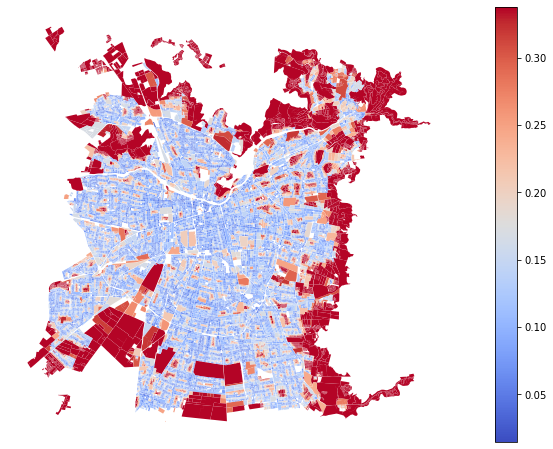

In [12]:
var_name = 'mean_distance'
vmin = blocks_transit[var_name].min()
vmax = blocks_transit[var_name].quantile(0.95)
plot_map(blocks_transit, var_name, vmin, vmax)

#### 5.1.1 Summed distance
Plots the column *summed_distance* for each city block. It uses the minimum value of the column for the minimum of the scale and the 95th percentile for the maximum. The graph shows how the outskirts of the city and various specific places in the middle of the city have the highest summed distance to the nearest stop.

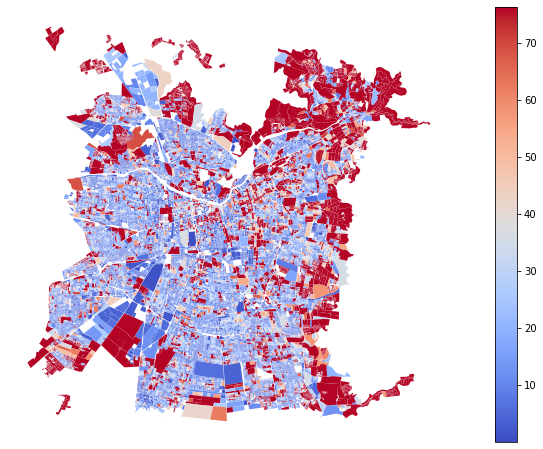

In [13]:
var_name = 'summed_distance'
vmin = blocks_transit[var_name].min()
vmax = blocks_transit[var_name].quantile(0.95)
plot_map(blocks_transit, var_name, vmin, vmax)

### 5.2 Quality
This part uses the columns *sum_n_buses* and *sum_n_routes* generated in section 4.3.2.

#### 5.2.1 Number of buses
Plots the column sum_n_buses for each city block. It uses the minimum value of the column for the minimum of the scale and the 95th percentile for the maximum. As for the colors, it uses a reversed *coolwarm* palette. The graph shows how the outskirts of the city have the lowest summed number of buses nearby. This also shows that the places with the best quality of public transport (according to this type of measure), are close to the main roads and highways of the city. This is a problem especially for the population in lower-income and low car-usage parts of the city, as they rely mostly on public transport.

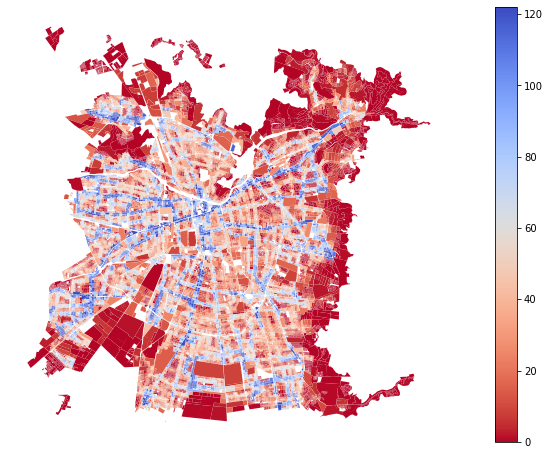

In [14]:
var_name = 'sum_n_buses'
vmin = blocks_transit[var_name].min()
vmax = blocks_transit[var_name].quantile(0.95)
plot_map(blocks_transit, var_name, vmin, vmax, cmap='coolwarm_r')

#### 5.2.2 Number of bus routes
Plots the column sum_n_routes for each city block. It uses the minimum value of the column for the minimum of the scale and the 95th percentile for the maximum. As for the colors, it uses a reversed *coolwarm* palette. The graph shows how the outskirts of the city have the lowest summed number of unique bus routes nearby. This also shows that the places with the best quality of public transport (according to this type of measure), are close to main roads and highways.  
This graph is almost equal to the one generated by *sum_n_buses* suggesting that there is not much difference between the two metrics.

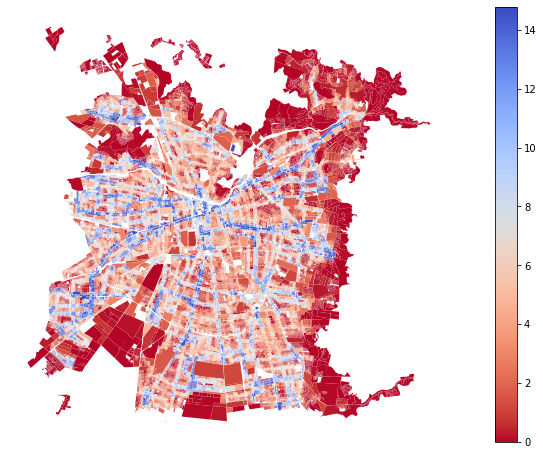

In [15]:
var_name = 'sum_n_routes'
vmin = blocks_transit[var_name].min()
vmax = blocks_transit[var_name].quantile(0.95)
plot_map(blocks_transit, var_name, vmin, vmax, cmap='coolwarm_r')

## 6. Discussion

### 6.1 Limitations

- This analysis uses a direct path to calculate the distance between each point and its nearby stops, but in reality, this path might be different.
- Because of the lack of a granular dataset, I simulated the position of each person in the city inside each city block using a uniform distribution. This is an assumption and might not reflect correctly the real world. As mitigation, I ran multiple simulations and obtained almost the same results every time.

### 6.2 Implications

The findings suggest that there are groups of people in the city that are being consistently left out, no matter what metric we use. These groups of people live mainly in the outskirts of the city, especially on the east side. This means that future additions of bus stops and metro stations should consider this information in order to benefit these groups. Also, current routes could be rearranged to lessen the current disparity.

## 7. Conclusion

This analysis has shown that the response to the question **Who is being left out by public transport?** depends on what we understand by *being left out*. If we consider *left out* as having a high distance to the nearest bus stop, we see that the outskirts of the city, especially the east-side are the most underserved. If we know consider *left out* as having a low number of buses or routes passing through the nearest stops, then the only areas well-served are the ones near main roads.  
However, despite the differences in the results obtained by each metric, there is one group that is constantly shown as having the worse quality and accessibility: the outskirts of the city. Future public policies should focus on these areas.

## References

[1] López, A. (2019). Mapa de viajes en el Gran Santiago. Accessed December 14, 2020 from https://ariellopez.carto.com/builder/a802cafa-15ff-47e9-8c1c-7cb663d2d7a9/embed